# Andres Graterol - 4031393 - Fall 22
# Homework 5

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# TODO: DEBUG KERAS
from tensorflow import keras

## Problem 1

In [15]:
# Initialize the weights 
number_of_classes_M = 2 
number_of_features_F = 5
# W is of size M x F (Each class (M) has 5 classes (F))

# Initialize the weights from a uniform pdf with bounds [-1, 1]
initial_weights = np.random.uniform(low=-1, high=1, 
                                   size=(number_of_classes_M, number_of_features_F))

In [29]:
#print(initial_weights)

# Number of data points 
N = 1000
points_per_class = math.floor(N/2)

# 1000 total training data points, 500 for each class
training_data_points_class0 = np.random.normal(loc=0, scale=1, size=(points_per_class, number_of_features_F))
training_data_points_class1 = np.random.normal(loc=0.1, scale=1, size=(points_per_class, number_of_features_F))

# Combine the two classes into one array 
training_data_points_old = np.concatenate((training_data_points_class0, training_data_points_class1))

# Make sure we keep track of indices to map the labels to
enum = list(enumerate(training_data_points_old))
random.shuffle(enum)
indices, training_data_points = zip(*enum)

training_data_points = np.array(training_data_points)

# Making sure that the shuffling has worked correctly 
print(training_data_points[0])
print(training_data_points_old[indices[0]])

labels_class0 = []
labels_class1 = []

# Create one-hot encoding formatting
for i in range(points_per_class):
    labels_class0.append([1, 0])
    labels_class1.append([0, 1])

labels_class0 = np.array(labels_class0)
labels_class1 = np.array(labels_class1)

# Labels array will be of size (N, 2)
labels = np.concatenate((labels_class0, labels_class1))

#print(labels_class0)
#print(labels_class1)

lr = 0.00005 
# Actually means 50 epochs (go through every 1000 points 50 times)
# We get a 1000 new weights every iteration
iterations = 50

[-0.93976513  0.10589197  0.0881246   0.88010835  0.3545333 ]
[-0.93976513  0.10589197  0.0881246   0.88010835  0.3545333 ]


In [41]:
# Function to compute gradient matrix for each point
def compute_gradient_matrix(point, label, output, number_of_classes, number_of_features):
    matrix = np.zeros((number_of_classes, number_of_features))

    for k in range(number_of_classes):
        for i in range(number_of_features):
            gradient = (output[k]-label[k])*point[i]
            matrix[k, i] = gradient

    return matrix

# Function to add individual point's gradient matrices together per iteration
def update_gradient_matrix(matrix1, matrix2):
    final_matrix = np.zeros((2, 5))

    for k in range(2):
        for i in range(5):
            final_matrix[k, i] = matrix1[k, i] + matrix2[k, i]

    return final_matrix

def map_to_class(prediction):
    if (prediction[0] > prediction[1]):
        # One-hot encoding for class 0
        prediction = [1, 0]
    else:
        # One-hot encoding for class 1
        prediction = [0, 1]
    
    return prediction

def compute_accuracy(prediction, label):    
    if (prediction[0] == label[0]):
        return 1

    return 0

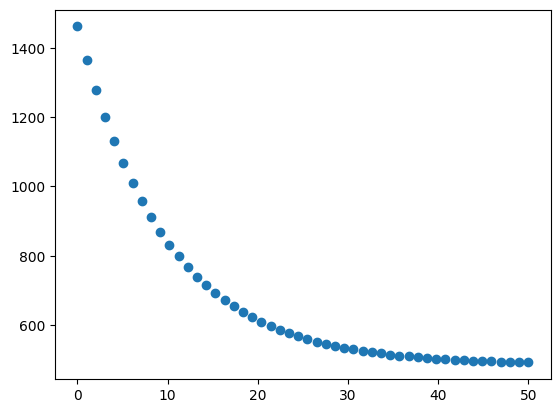

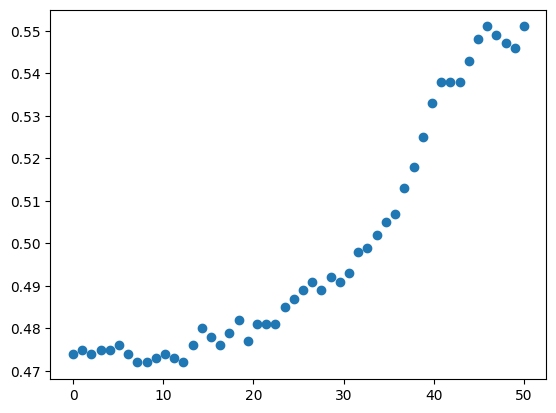

In [43]:
# Expecting 50 items in each of these 
accuracy_list = []
error_list = []
for i in range(iterations):
    
    # initialize a new gradient matrix to use for every iteration    
    gradient_matrix = np.zeros((number_of_classes_M, number_of_features_F))    
    iteration_error = 0
    correct_predictions = 0
    # Go through the 1000 data points every epoch
    for j in range(N):

        # If we are in the very first iteration, use the initial weights
        if (i == 0):
            # For some opbservation vector, x, of size F (number of features)
            # output is given by y(x) = Wx = (y1(x), y2(x))^T
            # Output is of size (2,) -> (2, 5) X (5,)

            # GET THE OUTPUT FOR EVERY DATA POINT
            output = np.matmul(initial_weights, training_data_points[j])
        else:
            output = np.matmul(updated_weights, training_data_points[j])

        # Compute classification accuracy
        prediction = map_to_class(output)
        correct_predictions += compute_accuracy(prediction, labels[indices[j]])

        #              (y1(x)     - tn1)^2
        error_class0 = (output[0] - labels[indices[j], 0])**2
        #              (y2(x)     - tn2)^2
        error_class1 = (output[1] - labels[indices[j], 1])**2   
        point_error = 0.5*error_class0 + 0.5*error_class1

        iteration_error += point_error   
        #error_list[i] = iteration_error

        # Now compute the gradient matrix for the point...
        point_matrix = compute_gradient_matrix(training_data_points[j], labels[indices[j]], output, number_of_classes_M, number_of_features_F)
        gradient_matrix = update_gradient_matrix(gradient_matrix, point_matrix)

    # Done with all the data points in an iteration
    accuracy = correct_predictions/N
    accuracy_list.append(accuracy)
    error_list.append(iteration_error)

    # New weights = weights from previous step - lr(gradients)
    if (i == 0):
        updated_weights = initial_weights - lr*(gradient_matrix)
    else:
        updated_weights = updated_weights - lr*(gradient_matrix)

#print(error_list)
x = np.linspace(0, iterations, 50)
plt.scatter(x, error_list)
plt.show()


plt.scatter(x, accuracy_list)
plt.show()

## Problem 2

In [7]:
number_of_feature = 13
number_of_units_in_hidden_layer = 100
#### load the BOSTON regression dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)
#### pre-process the data
x_train -= np.mean(x_train)
x_train /= np.std(x_train)
x_test -= np.mean(x_test)
x_test /= np.std(x_test)

NN_regression_model = tf.keras.Sequential()
hidden_layer_1 = tf.keras.layers.Dense(units=number_of_units_in_hidden_layer, activation='relu') # define layer
NN_regression_model.add(hidden_layer_1) # add layer
hidden_layer_2 = tf.keras.layers.Dense(units=number_of_units_in_hidden_layer,
    activation='relu') # define layer
NN_regression_model.add(hidden_layer_2) # add layer
output_layer = tf.keras.layers.Dense(units=1, activation=None) # define layer
    #(units = 1 for regression)
NN_regression_model.add(output_layer) # add layer
  
  
# Compile the model
# TODO: ASK PROF ABOUT THIS STEP
NN_regression_model.compile(optimizer="Adam", loss="mse")
NN_regression_model.fit(x_train, y_train, epochs=100, batch_size = 1)
train_error_mse = NN_regression_model.evaluate(x_train, y_train)
test_error_mse = NN_regression_model.evaluate(x_test, y_test)
print("MSE on training data = {} ; MSE of testing data ={}".format(train_error_mse, test_error_mse))


Epoch 1/100
404/404 [==============================] - 1s 2ms/step - loss: 138.0253
Epoch 2/100
404/404 [==============================] - 1s 2ms/step - loss: 64.7921
Epoch 3/100
404/404 [==============================] - 1s 2ms/step - loss: 63.8208
Epoch 4/100
404/404 [==============================] - 1s 2ms/step - loss: 63.3310
Epoch 5/100
404/404 [==============================] - 1s 1ms/step - loss: 61.4245
Epoch 6/100
404/404 [==============================] - 1s 2ms/step - loss: 60.7674
Epoch 7/100
404/404 [==============================] - 1s 2ms/step - loss: 58.0719
Epoch 8/100
404/404 [==============================] - 1s 2ms/step - loss: 59.0796
Epoch 9/100
404/404 [==============================] - 1s 2ms/step - loss: 58.4748
Epoch 10/100
404/404 [==============================] - 1s 2ms/step - loss: 58.2541
Epoch 11/100
404/404 [==============================] - 1s 2ms/step - loss: 59.1585
Epoch 12/100
404/404 [==============================] - 1s 2ms/step - loss: 56.2647
